In [3]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.common import ListDataset
from datetime import datetime, timedelta
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.util import to_pandas
from gluonts.dataset.field_names import FieldName
from gluonts.model.forecast import SampleForecast
from pandas import Timestamp
import itertools
from gluonts.model.estimator import GluonEstimator

# Data Loading

In [4]:
filename='EstimatedRemainingTimeContext'

In [5]:
dataset= pd.read_csv(filename + ".csv")
X= dataset[['name','time', 'countryCode', 'ipAddress', 'level',
 'producer']]
y= dataset.iloc[:,6]
#changing the names of the attributes
gluon_dataset= pd.DataFrame()
gluon_dataset['ds'] = pd.to_datetime(X["time"])
gluon_dataset['y']=y
gluon_dataset['ds'] = gluon_dataset['ds'].dt.tz_convert(None)
gluon_dataset_copy=gluon_dataset.copy()

In [6]:
gluon_dataset_copy

ds         y
0    2021-02-12 12:03:17.090  4162.500
1    2021-02-12 12:03:37.090  4162.500
2    2021-02-12 12:04:07.090  4157.875
3    2021-02-12 12:04:37.090  4157.875
4    2021-02-12 12:05:07.090  4265.500
...                      ...       ...
2177 2021-02-13 06:12:07.090     9.000
2178 2021-02-13 06:12:37.090     9.000
2179 2021-02-13 06:13:07.090     9.000
2180 2021-02-13 06:13:37.090     0.000
2181 2021-02-13 06:14:07.090     0.000

[2182 rows x 2 columns]

In [7]:
for i in range(0,len(gluon_dataset_copy)):
    ds=gluon_dataset_copy['ds'][i]
    gluon_dataset_copy['ds'][i+1]=ds + timedelta(seconds=60)
    ds=gluon_dataset['ds'][i]
    gluon_dataset['ds'][i+1]=ds + timedelta(seconds=60)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Data Transformation

In [8]:
# Cube root transformation
def cube_root_transformation(x: pd.Series) -> pd.Series:
    return x ** (1 / 3)

def cube_root_inverse_transformation(x: pd.Series) -> pd.Series:
    return x ** 3

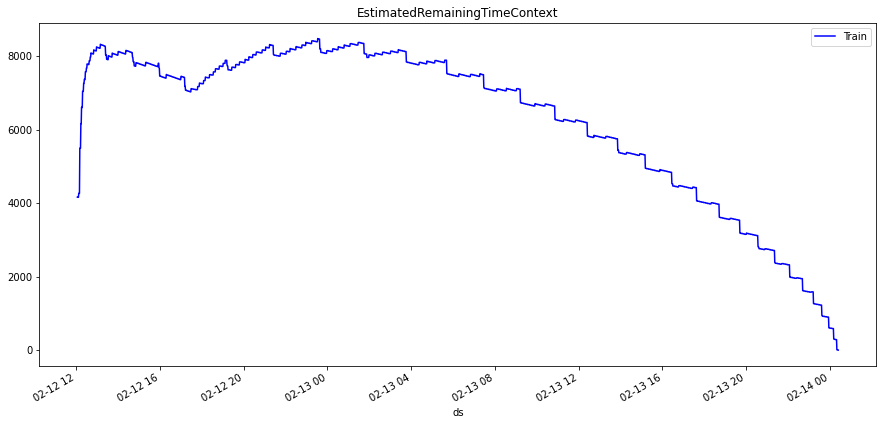

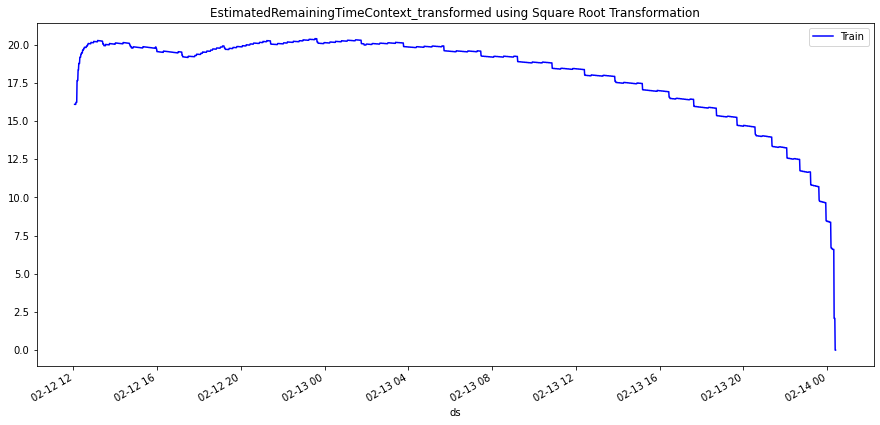

In [9]:
gluon_dataset_copy['y_orig']=gluon_dataset_copy['y']
transformed = cube_root_transformation(gluon_dataset_copy['y'])
gluon_dataset_copy['y']=transformed

#plot before transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y_orig', color='blue', label='Train', ax=ax)
plt.title(filename)
plt.show()

#plot after transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
#test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title(filename + "_transformed using Square Root Transformation")
plt.show()

In [10]:
gluon_dataset_copy

ds          y    y_orig
0    2021-02-12 12:03:17.090  16.086124  4162.500
1    2021-02-12 12:04:17.090  16.086124  4162.500
2    2021-02-12 12:05:17.090  16.080164  4157.875
3    2021-02-12 12:06:17.090  16.080164  4157.875
4    2021-02-12 12:07:17.090  16.217727  4265.500
...                      ...        ...       ...
2177 2021-02-14 00:20:17.090   2.080084     9.000
2178 2021-02-14 00:21:17.090   2.080084     9.000
2179 2021-02-14 00:22:17.090   2.080084     9.000
2180 2021-02-14 00:23:17.090   0.000000     0.000
2181 2021-02-14 00:24:17.090   0.000000     0.000

[2182 rows x 3 columns]

# Splitting Data into Training and Testing

In [11]:
gluon_dataset_copy=gluon_dataset_copy.set_index('ds')
gluon_dataset=gluon_dataset.set_index('ds')
validation_time =  "2021-02-13 15:00:00"
train_time = "2021-02-13 20:00:00"
test_time = "2021-02-14 00:24:17"
freq='1min'

In [12]:
validation_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:train_time]}],
                         freq=freq
                      )
train_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:validation_time]}],
                         freq=freq
                      )
test_ds = ListDataset([{"start":gluon_dataset_copy.index[0],
                        "target":gluon_dataset_copy.y[:test_time]}],
                        freq=freq
                     )
test_orig_ds = ListDataset([{"start":gluon_dataset.index[0],
                        "target":gluon_dataset.y[:test_time]}],
                        freq=freq
                     )

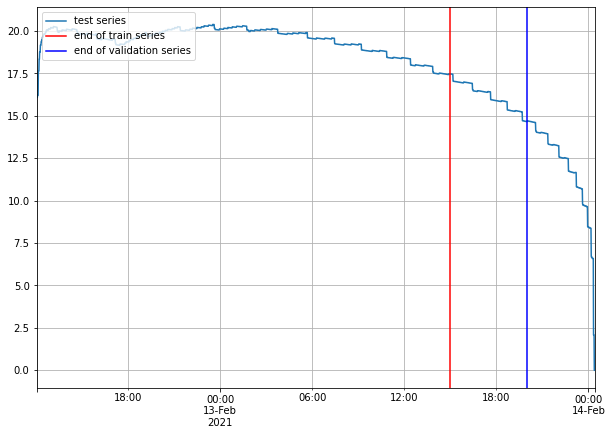

In [13]:
train_entry = next(iter(train_ds))
train_entry.keys()

validation_entry = next(iter(validation_ds))
validation_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

test_orig_entry = next(iter(test_orig_ds))
test_orig_entry.keys()

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)
validation_series = to_pandas(validation_entry)

prediction_length = len(test_series) - len(validation_series)
context_length = [50,60]


list1=train_series.index
list2=train_entry['target']

d = {'ds':list1,'y':list2}
df_train=pd.DataFrame(d, columns=['ds','y'])

fig, ax = plt.subplots( figsize=(10, 7))

# train_series.plot(ax=ax[0])
# ax[0].grid(which="both")
# ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax)
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(validation_series.index[-1], color='b') # end of validation dataset
ax.grid(which="both")
ax.legend(["test series", "end of train series","end of validation series"], loc="upper left")

plt.show()

In [14]:
prediction_length

265

# Hyper-parameter Tuning

In [15]:
batch_size = [75,100]
epochs = [5,10]
num_batches_per_epoch = [10,20]
learning_rate = [1e-3,1e-4]

In [16]:
from sklearn.model_selection import ParameterGrid

param_grid = {'batch_size': batch_size,
              'epochs': epochs,
              'num_batches_per_epoch': num_batches_per_epoch,
              'learning_rate': learning_rate,
              'context_length': context_length
             }
grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 32


In [17]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
agg_metrics_all=list()
item_metrics_all=list()
for params in all_params:
    estimator = DeepAREstimator(
                        #num_hidden_dimensions=[params['num_hidden_dimensions']],
                        prediction_length=prediction_length,
                        context_length=params['context_length'],
                        freq=freq,
                        trainer=Trainer(ctx="cpu",
                                        epochs=params['epochs'],
                                        learning_rate=params['learning_rate'],
                                        num_batches_per_epoch=params['num_batches_per_epoch']
                                       )
                )
    predictor = estimator.train(training_data = train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=validation_ds,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=20,  # number of sample paths we want for evaluation
                         )
    forecasts = list(forecast_it)
    #print(forecasts)
    tss = list(ts_it)
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    #agg_metrics['num_hidden_dimensions'] = params['num_hidden_dimensions']
    agg_metrics['epochs'] = params['epochs']
    agg_metrics['learning_rate'] = params['learning_rate']
    agg_metrics['num_batches_per_epoch'] = params['num_batches_per_epoch']
    agg_metrics['context_length'] = params['context_length']
    agg_metrics['forecast'] = forecasts
    agg_metrics_all.append(agg_metrics)
    item_metrics_all.append(item_metrics)
    
dataframe = pd.DataFrame(agg_metrics_all)
print(dataframe)
sorted1 = dataframe.sort_values(by=['MAPE'])
sorted1 = sorted1.reset_index(drop=True)

  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


           MSE    abs_error  abs_target_sum  abs_target_mean  seasonal_error  \
0     0.434107   153.154022     4247.697266        16.029046        0.010048   
1     0.936379   199.404572     4247.697266        16.029046        0.010048   
2    12.745057   788.211121     4247.697266        16.029046        0.010048   
3     5.068043   480.070129     4247.697266        16.029046        0.010048   
4     1.821935   314.693970     4247.697266        16.029046        0.010048   
5     0.830552   197.510040     4247.697266        16.029046        0.010048   
6     5.928562   439.101257     4247.697266        16.029046        0.010048   
7    15.126757   610.010620     4247.697266        16.029046        0.010048   
8     4.667158   543.882019     4247.697266        16.029046        0.010048   
9     1.133161   232.612335     4247.697266        16.029046        0.010048   
10    1.871941   257.726196     4247.697266        16.029046        0.010048   
11    5.788454   548.278931     4247.697

# Forecast and Evaluation

In [18]:
estimator = DeepAREstimator(
    #num_hidden_dimensions=[sorted1['num_hidden_dimensions'][0]],
    prediction_length=prediction_length,
    context_length=sorted1['context_length'][0],
    freq=freq,
    trainer=Trainer(ctx="cpu",
                    epochs=sorted1['epochs'][0],
                    learning_rate=learning_rate[0],
                    num_batches_per_epoch=sorted1['num_batches_per_epoch'][0]
                   )
)



In [19]:
predictor = estimator.train(train_ds)

  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 20/20 [00:08<00:00,  2.49it/s, epoch=10/10, avg_epoch_loss=0.322]


# Save the model

In [20]:
from pathlib import Path
predictor.serialize(Path("Models/CubeRoot"))

# loads it back
# from gluonts.model.predictor import Predictor
# predictor_deserialized = Predictor.deserialize(Path("Models/CubeRoot"))
# print(predictor_deserialized)

In [21]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=50,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

forecasts_val=sorted1['forecast'][0]
forecast_entry_val = forecasts_val[0]



In [22]:
#return forecast to original
inv = np.vectorize(cube_root_inverse_transformation)

forecast_entry.samples = inv(forecast_entry.samples)
forecast_entry_inv=SampleForecast(freq=freq, start_date=forecast_entry.start_date, samples=forecast_entry.samples)

forecast_entry_val.samples = inv(forecast_entry_val.samples)
forecast_entry_val_inv=SampleForecast(freq=freq, start_date=forecast_entry_val.start_date, samples=forecast_entry_val.samples)

ts_entry_inv=inv(ts_entry)
ts_entry_inv_df=pd.DataFrame(ts_entry_inv, index=ts_entry.index)
tss_inv=list()
tss_inv.append(ts_entry_inv_df)

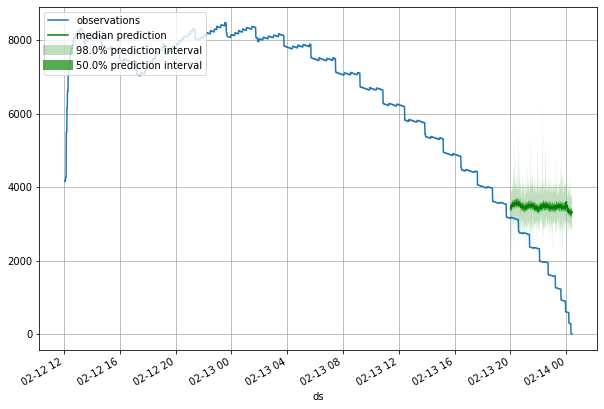

In [23]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = len(ts_entry)
    prediction_intervals = (50.0,98.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(gluon_dataset['y'], forecast_entry_inv)

In [24]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss_inv), iter([forecast_entry_inv]), num_series=len(test_ds))


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


In [25]:
agg_metrics

{'MSE': 2944802.9635223467,
 'abs_error': 397535.530295986,
 'abs_target_sum': 520654.12967662513,
 'abs_target_mean': 1964.7325648174533,
 'seasonal_error': 10.608233064989085,
 'MASE': 141.41224720444714,
 'MAPE': 5.49471772057327,
 'sMAPE': 0.6259764972526529,
 'OWA': nan,
 'MSIS': 4363.447994972807,
 'QuantileLoss[0.1]': 619288.97520732,
 'Coverage[0.1]': 1.0,
 'QuantileLoss[0.5]': 397535.530295986,
 'Coverage[0.5]': 1.0,
 'QuantileLoss[0.9]': 91044.0757387477,
 'Coverage[0.9]': 1.0,
 'RMSE': 1716.0428210048683,
 'NRMSE': 0.8734231069073306,
 'ND': 0.7635309270338309,
 'wQuantileLoss[0.1]': 1.1894440856388795,
 'wQuantileLoss[0.5]': 0.7635309270338309,
 'wQuantileLoss[0.9]': 0.17486479132566293,
 'mean_absolute_QuantileLoss': 369289.5270806845,
 'mean_wQuantileLoss': 0.7092799346661245,
 'MAE_Coverage': 0.5}

# Residual

In [26]:
#get the mean for all the samples
f1 = forecast_entry_val_inv.samples.mean(axis=0)
f2 = forecast_entry_inv.samples.mean(axis=0)

In [27]:
original_values=list(gluon_dataset['y'])
orig_test = original_values[:len(original_values)-prediction_length]
test_extract=original_values[-prediction_length:]
val_extract=orig_test[-prediction_length:]

In [28]:
valandtest_orig=list()
valandtest_pred=list()
for a1 in val_extract:
    valandtest_orig.append(a1)

for b1 in test_extract:
    valandtest_orig.append(b1)
    
for a2 in f1:
    valandtest_pred.append(a2)

for b2 in f2:
    valandtest_pred.append(b2)


Text(0.5, 1.0, 'Residuals')

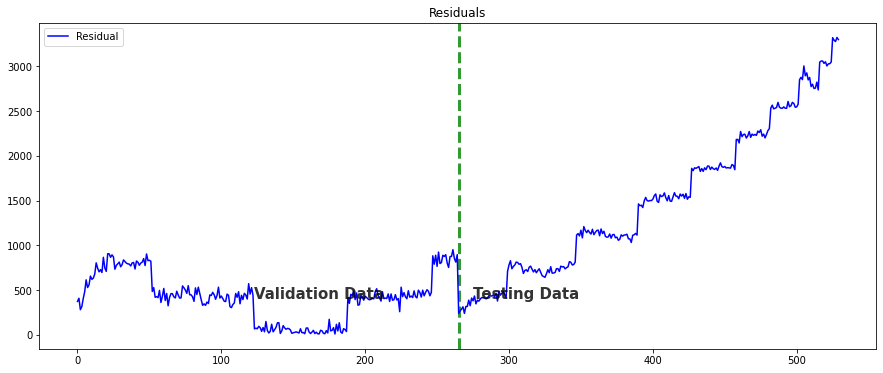

In [29]:
residuals = abs(np.array(valandtest_pred)-np.array(valandtest_orig))
residuals_df=pd.DataFrame()
residuals_df['residuals']=residuals
#residuals_df['ds']=prophet_dataset2['ds']

f, ax = plt.subplots(figsize=(15,7))
ax.text(x=len(val_extract)/2 -10,y=400, s='Validation Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.text(x=len(val_extract)+10,y=400, s='Testing Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.axvline(x=len(val_extract), c='green', lw=3, alpha=0.8, ls='--')
residuals_df.plot(kind='line',  y='residuals', color='blue', label='Residual',figsize=(15, 6),ax=ax)
plt.title("Residuals")

# Save the predictions

In [30]:
predictions_df=pd.DataFrame()
predictions_df['original'] = valandtest_orig
predictions_df['predictions'] = valandtest_pred
predictions_df.to_csv(Path("Predictions/CubeRoot.csv"),index=False)